
# Boston House Prices
In this notebook we are going to build a predictive regression model for esitmating the house prices in thousands of $ given some housing factors such as crime rate in neighborhood, number of schools %, lower status of the population etc.

We will apply and elaborate the steps seen in the first Workshop (when applicable).




<dl></dl>
<dl></dl>

**Data Science Cycle:**

    Data Understanding
        0. Exploratory Data Analysis
        
    Data Preparation
        1. Target Definition
        2. Data Splitting
        3. Feature Engineering
    
    Modeling
        4. Variable Selection
        5. Model Selection
        6. Fine-tuning

    Evaluation
        7. Evaluation & Interpretation


# Set Up
Import required libraries

In [2]:
# Boston Data
from sklearn.datasets import load_boston

# Data Manipulation & analysis
import pandas as pd
import numpy as np
from scipy import stats

# Visualizations
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preparation
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split

# Modeling
from boruta import BorutaPy 
import statsmodels.api as sm 
import sklearn
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import RandomizedSearchCV 
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
import xgboost as xgb
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.inspection import plot_partial_dependence

# Other Set Up
from datetime import datetime
import os
import warnings
from pprint import pprint

In [3]:
# Set style for displaying data
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Set style for plotting
sns.set_style("whitegrid")

In [4]:
# Set timer
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [5]:
# Fix Random seed for reproducibility
np.random.seed(42)

# Exploratory Data Analysis

We will start by exploring Boston data and setting the target.

Boston dataset is extremely common in machine learning experiments thus it is embedded in sklearn.

In [6]:
# Read Data
boston = load_boston()

Detailed description of dataset and features

In [6]:
# Print dataset description
print (boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Create pandas dataframe with objects in rows and features in columns, and define target.
In this study, the target is already given as being the housing price (i.e. "MEDV", or the Median value of owner-occupied homes in $1000's)

In [7]:
# Set panda dataframe
boston_data = pd.DataFrame(boston.data)

# Set column names
boston_data.columns = boston.feature_names

# Set target
boston_target=pd.DataFrame(boston.target)
boston_target.columns=['PRICE']

# Merge into 1 data frame
boston_df = pd.merge(boston_data,boston_target,left_index = True, right_index = True)

# Set X and Y (features and target)
X = pd.DataFrame(boston.data, columns=boston.feature_names)
Y = boston.target

In [8]:
# Check first few rows of data
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [9]:
# Get descriptive statistics
boston_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Note that some of the features are categorical and some are continious.

Let's look at how these features correlate with each other.

(14.5, -0.5)

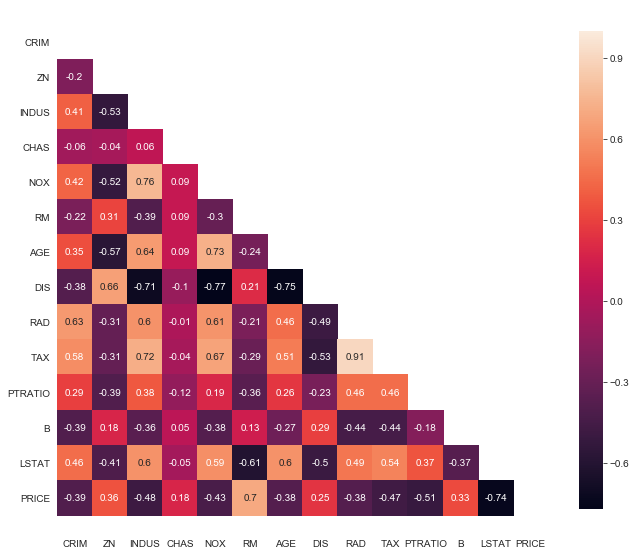

In [10]:
# Compute correlation matrix
corr = boston_df.corr().round(2)

# Set figure options
fig,  ax = plt.subplots(figsize=(11,11),nrows=1)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Generate heatmap including mask, and correct aspect ratio
sns.heatmap(corr, mask=mask, square=True,annot=True, cbar_kws={"shrink": .8})

# Fix axis
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

We see that RM (0.7),  PTRATION (-0.51) and LSTAT (-0.74) correlate highly with our target, housing prices.
As a reminder:
        - RM       average number of rooms per dwelling
        - PTRATIO  pupil-teacher ratio by town
        - LSTAT    % lower status of the population

    
      

Let's see these correlations as well as their distributions. 

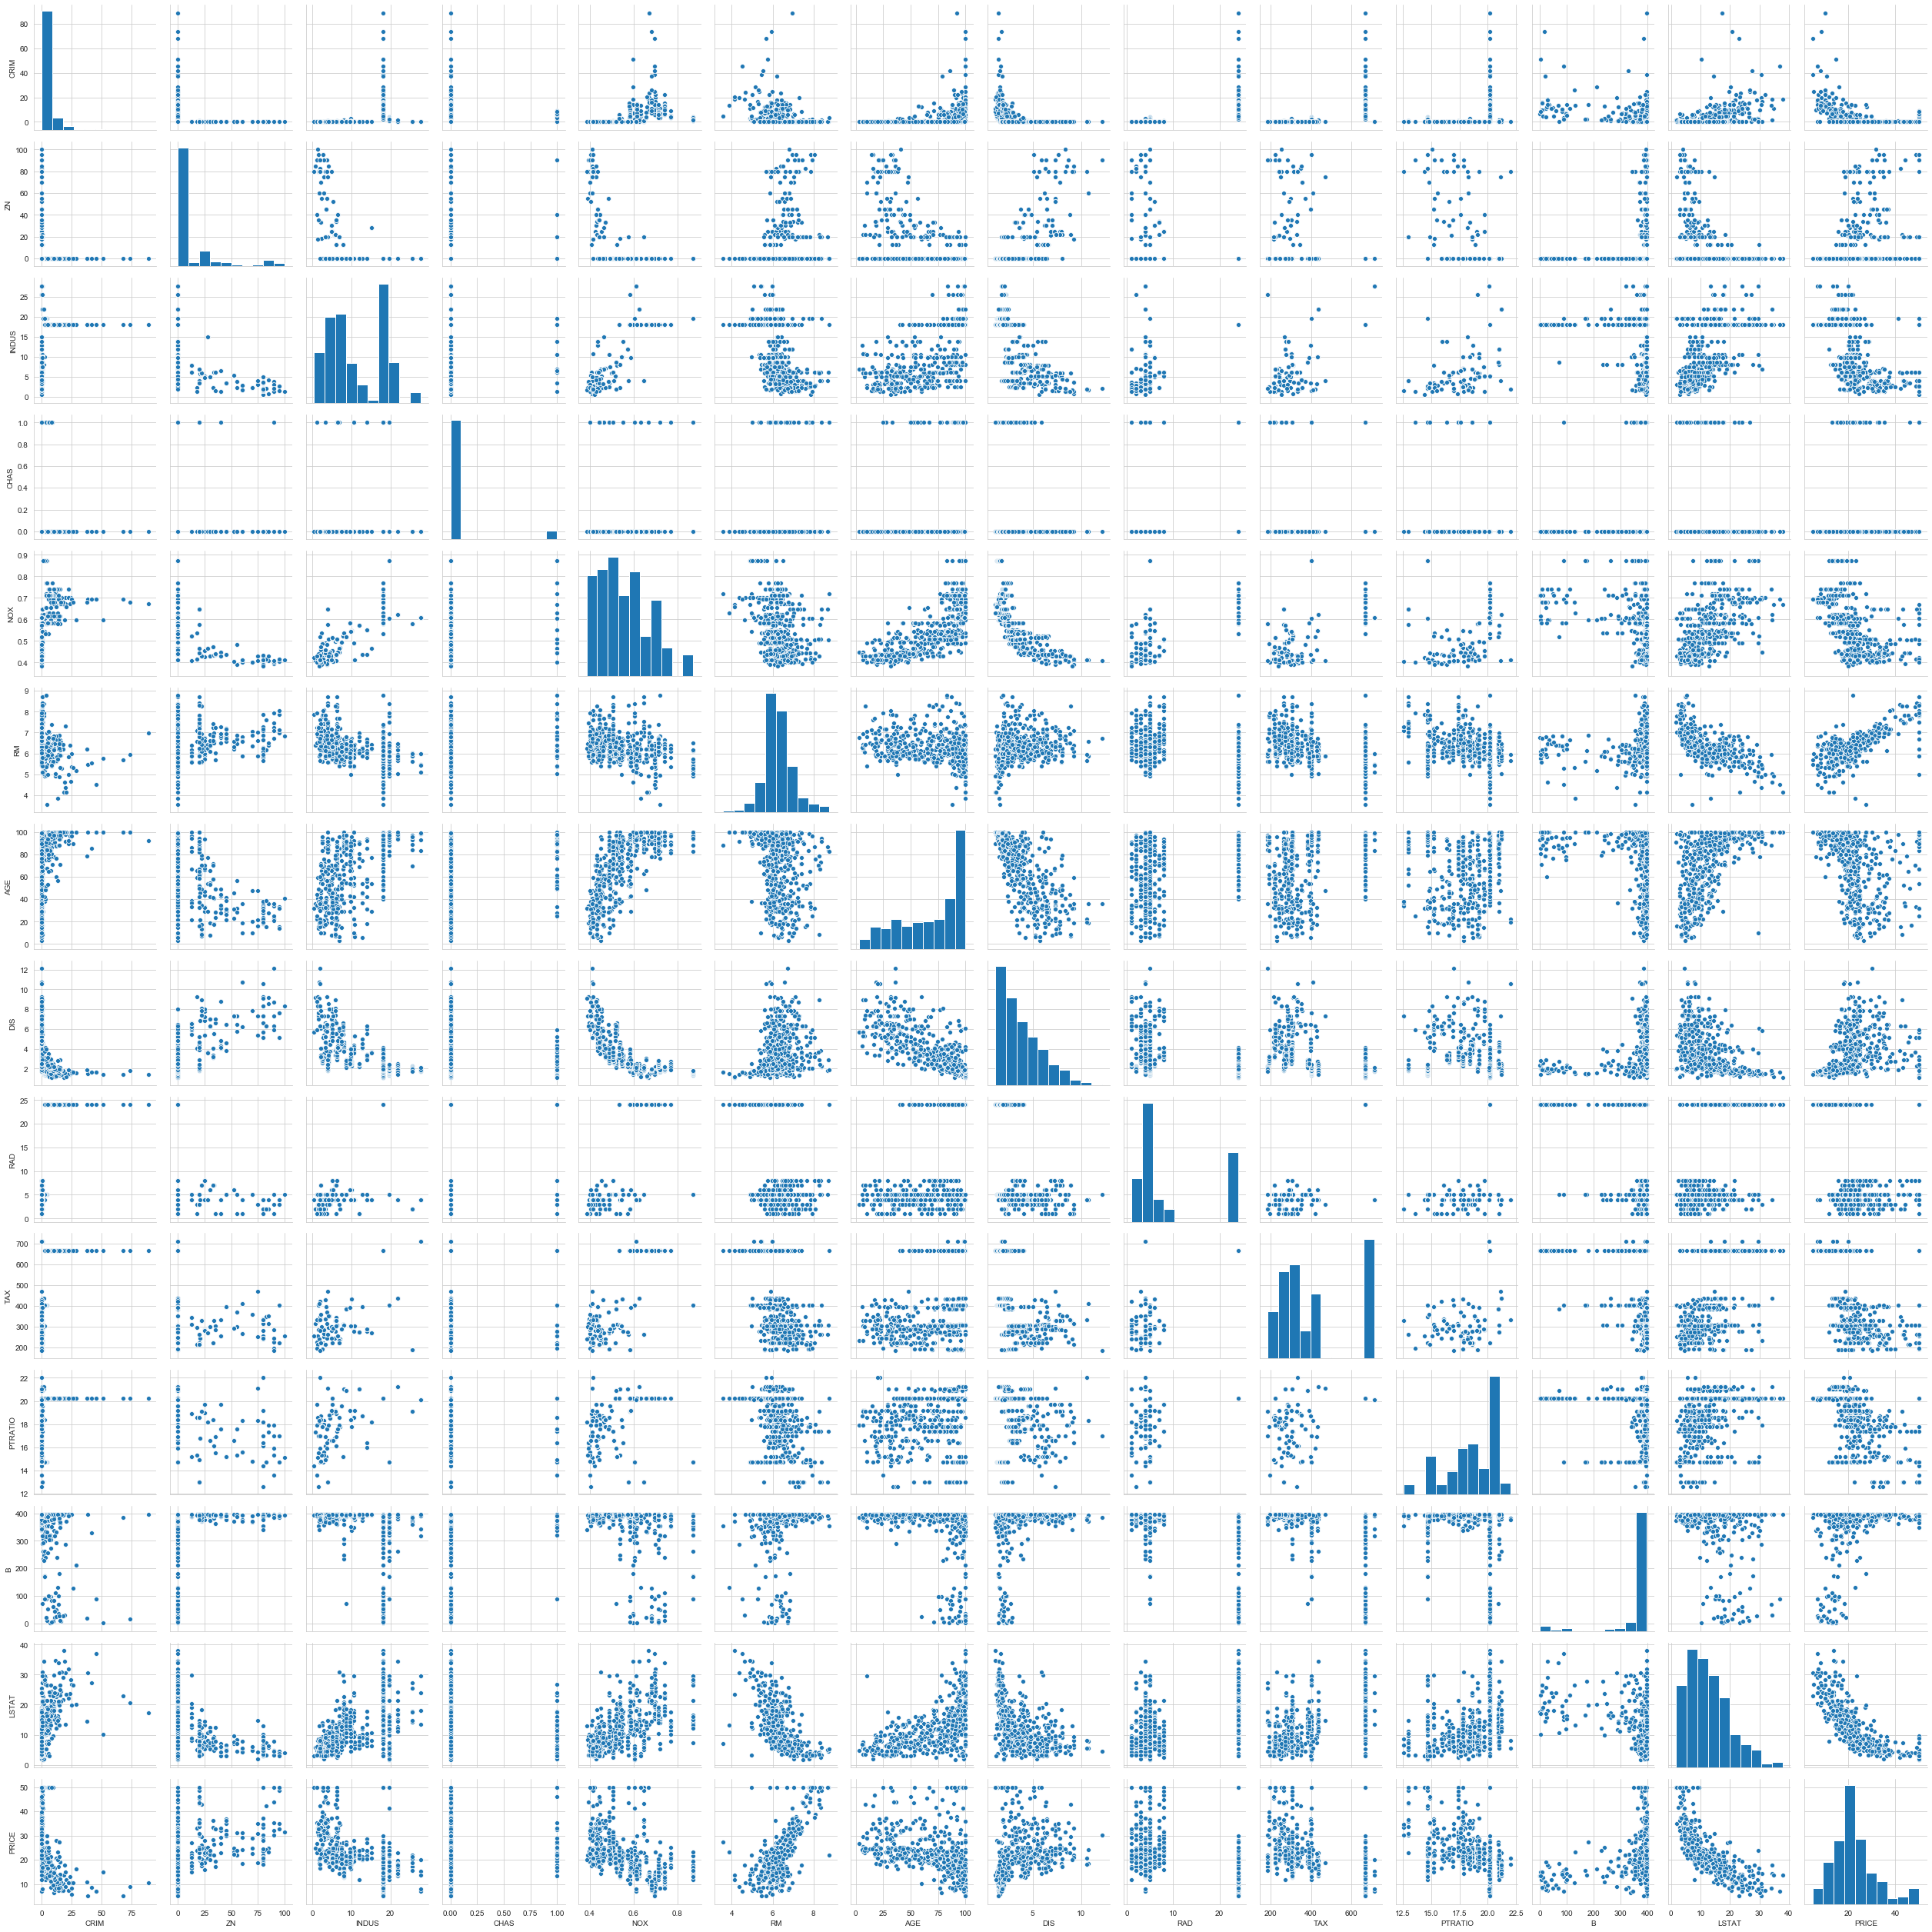

In [11]:
%matplotlib inline
# Calculate and show pairplot
sns.pairplot(boston_df, height=2.5)
plt.tight_layout()

Indeed, we can see a correlation. Let's have a closer at these variables.

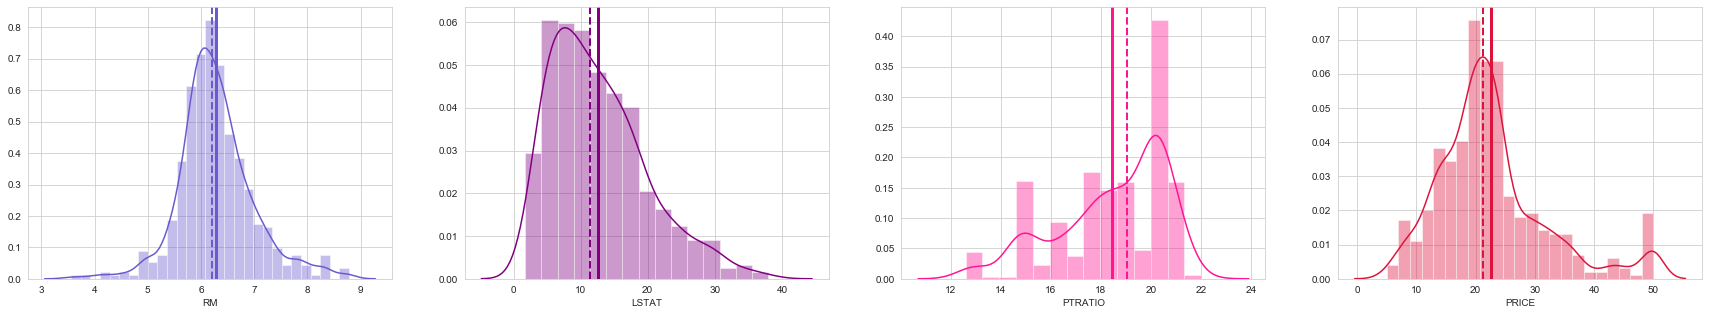

In [8]:
# Set colors
clr = ['slateblue', 'purple', 'deeppink','crimson'] 

## Create plots for Univariate distributions, means, medians

# Create  empty subplots
fig,  ax = plt.subplots(ncols=4,figsize=(30,5),nrows=1)

# Select features to check and loop through
for i, var in enumerate(['RM', 'LSTAT', 'PTRATIO', 'PRICE']):
    sns.distplot(boston_df[var],  color = clr[i], ax=ax[i])
    ax[i].axvline(boston_df[var].mean(), color=clr[i], linestyle='solid', linewidth=3)
    ax[i].axvline(boston_df[var].median(), color=clr[i], linestyle='dashed', linewidth=2)

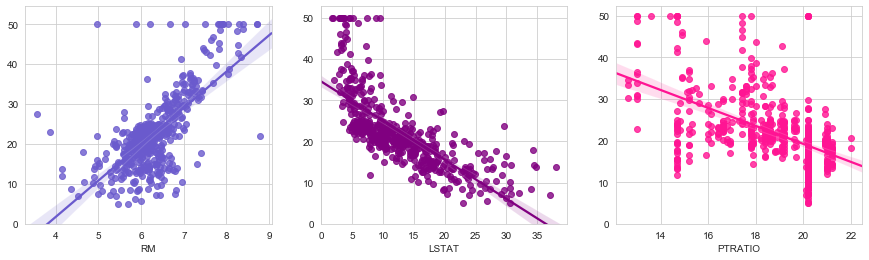

In [13]:
## Create plots for bivariate analayis with select X and Y

# Create empty subplots
fig, ax = plt.subplots(ncols=3,figsize=(15,4))

# Select features to check and loop through
for i, var in enumerate(['RM', 'LSTAT', 'PTRATIO']):
    sns.regplot(boston_df[var], Y, color=clr[i], ax=ax[i])
    ax[i].set(ylim=(0, None))

The target variable has already been pre-defined in this study, having the following characteristics:

    Target: Median value of owner-occupied homes in $1000’s.
    Subject: Owner-occupied homes, leaving out homes that are rented out.
    Granularity: Suburb or town in Boston.
    Time Window: Snapshot of 1978. No dependent or independent period.

# Data Preparation

Since this is an academic data set, Data Modeling step is not required and Feature Engineering step is minimal as the data has already been carefully designed and cleaned.

Let's split the data for testing purpose (Data Splitting step). We will set 10% of data aside. 

We can apply normalization to the range of 0 and 1 to make our data insensitive to the scale of features. (Feature Engineering step)

In [14]:
# Create train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

# Scale from 0 to 1
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) #

# This step is needed so that var selection methods can bring us column names - otherwise, 
# X_Train and Y_train are just numpy arrays, which is efficient for algorithm fitting but not for var selection 
X_train_df=pd.DataFrame(X_train)
X_train_df.columns = boston.feature_names
X_test_df=pd.DataFrame(X_test)
X_test_df.columns = boston.feature_names

(455, 13)
(51, 13)
(455,)
(51,)


In [15]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

There are a lot of features, let's visualize two of them

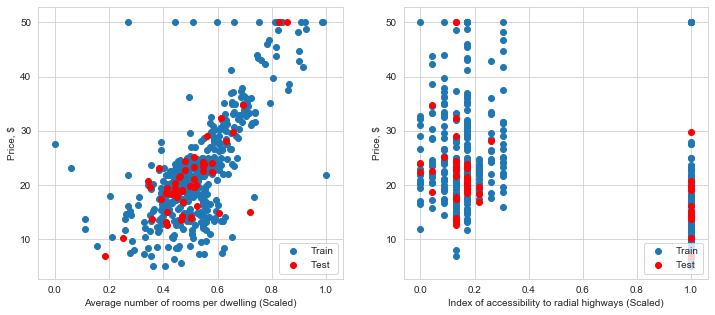

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.scatter(X_train_df.RM, Y_train, label="Train")
plt.scatter(X_test_df.RM, Y_test, c="r", label="Test")
plt.xlabel("Average number of rooms per dwelling (Scaled)")
plt.ylabel("Price, $")
plt.legend(loc="lower right", frameon=True)
plt.subplot(122)
plt.scatter(X_train_df.RAD, Y_train, label="Train")
plt.scatter(X_test_df.RAD, Y_test, c="r", label="Test")
plt.xlabel("Index of accessibility to radial highways (Scaled)")
plt.ylabel("Price, $")
plt.legend(loc="lower right", frameon=True)

# Modeling

Now our data is ready, we can start modeling steps.

### Variable Selection

We start by keeping the best variables only (Variable Selection step) using the following methods:
    1. Stepwise Regression
    2. Boruta

In [17]:
## Variable Selection Method 1: Stepwise Selection

# Define the function which can be used with AIC
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.15, 
                       threshold_out = 0.2, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [18]:
# Run Stepwise Feature Selection
result = stepwise_selection(X_train_df, Y_train) #need column names here, so not using train

print('resulting features:')
print(result)

/Users/kriztian.modrovics/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/kriztian.modrovics/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


Add  LSTAT                          with p-value 9.81986e-79
Add  RM                             with p-value 5.35385e-24
Add  PTRATIO                        with p-value 2.27473e-12
Add  DIS                            with p-value 7.07057e-06
Add  NOX                            with p-value 4.33386e-07
Add  B                              with p-value 0.000200867
Add  CHAS                           with p-value 0.000866129
Add  RAD                            with p-value 0.0230918
Add  CRIM                           with p-value 0.00143563
Add  TAX                            with p-value 0.0128806
Add  ZN                             with p-value 0.00795547
resulting features:
['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX', 'B', 'CHAS', 'RAD', 'CRIM', 'TAX', 'ZN']


Stepwise Feature Selection tells us to keep:

        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        
Which means, removing:
        - INDUS    proportion of non-retail business acres per town
        - AGE      proportion of owner-occupied units built prior to 1940


In [19]:
## Variable Selection Method 2: Boruta Selection

rf = RandomForestRegressor(n_jobs=-1)

#so Boruta runs, transform df to np arrayss
y2=np.ravel(Y_train) #for the warning to be sorted
y2
X2=np.array(X_train_df)
X2

#running boruta
boruta_feature_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=4242, max_iter = 30, perc = 90)
boruta_feature_selector.fit(X2, y2)

Iteration: 	1 / 30
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	2 / 30
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	3 / 30
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	4 / 30
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	5 / 30
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	6 / 30
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	7 / 30
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	8 / 30
Confirmed: 	9
Tentative: 	1
Rejected: 	3
Iteration: 	9 / 30
Confirmed: 	9
Tentative: 	1
Rejected: 	3
Iteration: 	10 / 30
Confirmed: 	9
Tentative: 	1
Rejected: 	3
Iteration: 	11 / 30
Confirmed: 	9
Tentative: 	1
Rejected: 	3
Iteration: 	12 / 30
Confirmed: 	9
Tentative: 	1
Rejected: 	3
Iteration: 	13 / 30
Confirmed: 	9
Tentative: 	1
Rejected: 	3
Iteration: 	14 / 30
Confirmed: 	9
Tentative: 	1
Rejected: 	3
Iteration: 	15 / 30
Confirmed: 	9
Tentative: 	1
Rejected: 	3
Iteration: 	16 / 30
Confirmed: 	9
Tentative: 	1
Rejected: 	3
Iteration: 	17 / 30
Confir

BorutaPy(alpha=0.05,
         estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                         criterion='mse', max_depth=None,
                                         max_features='auto',
                                         max_leaf_nodes=None, max_samples=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=44, n_jobs=-1,
                                         oob_score=False,
                                         random_state=<mtrand.RandomState object at 0x10fc52870>,
                                         verbose=0, warm_start=False),
         max_iter=30, n_estimators='auto', perc=90,
         random

In [20]:
# Show which features have been selected
features = [f for f in X_train_df.columns]
final_features = list()
indexes = np.where(boruta_feature_selector.support_ == True)
for x in np.nditer(indexes):
    final_features.append(features[x])
list(final_features)

['CRIM', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']

Stepwise Feature Selection tells us to keep:
        - CRIM     per capita crime rate by town
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        
Which means, removing:
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - RAD      index of accessibility to radial highways
        
        
In summary, both methods (Stepwise & Boruta) tell us to remove INDUS, we can give the others the benefit of doubt until further iterations.

In [21]:
#we can overwrite original df-s with selected variables
X_train = X_train_df[['CRIM', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT','ZN','CHAS','RAD']]
X_test = X_test_df[['CRIM', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT','ZN','CHAS','RAD']]
#Y_train = Y_train_df
#Y_test = Y_test_df

### Model Selection

We will fit several ML algorithms and compare performance:
    - Linear Regression
    - Lasso Regression
    - Decision Tree Regressor
    - Random Forest Regressor
    - XGBoost Regressor
    - Feedforward Neural Network
        

In [22]:
# Set model: Simple Linear Regression
LR_model = LinearRegression().fit(X_train,Y_train)

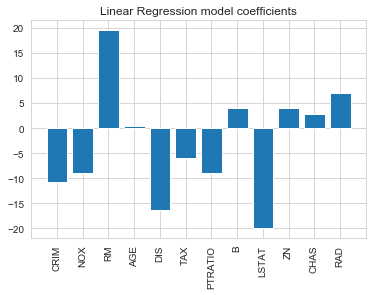

In [23]:
# Additional Insights
# Visualize Coefficients
sns.set_style("whitegrid")
plt.bar(np.arange(LR_model.coef_.shape[0]), LR_model.coef_)
plt.xticks(np.arange(LR_model.coef_.shape[0]), X_train.columns, rotation='vertical')
plt.xlim([-1, LR_model.coef_.shape[0]])
plt.title("Linear Regression model coefficients")
plt.show()

Predicting both train and test sets to evaluate model

In [24]:
# Predict
preds_test = LR_model.predict(X_test)
preds_train = LR_model.predict(X_train)

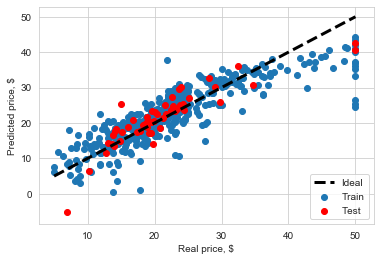

In [25]:
# For illustration Purpose
# It also interesting to take a look how the predicted points relate to real ones.
# All the points should lie on the black dotted line assuming that our model is perfect
plt.scatter(Y_train, preds_train, label="Train")
plt.scatter(Y_test, preds_test, c="r", label="Test")
plt.xlabel("Real price, $")
plt.ylabel("Predicted price, $")
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=3, label="Ideal")
plt.legend(loc="lower right", frameon=True)
plt.show()

Let's evaluate our model according to three different metrics:
    - MAE (Mean Absolute Error)
    - RMSE (Root Mean Squared Error)
    - R2 (R Squared)

In [26]:
# Linear Regression 
# LR_model = LinearRegression()

# Cross-validate model and store scores
LR_score_MAE = cross_val_score(LR_model, X_train, Y_train, cv=5, scoring='neg_mean_absolute_error').mean().round(2)
LR_score_MSE = cross_val_score(LR_model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error').mean().round(2)
LR_score_R2 = cross_val_score(LR_model, X_train, Y_train, cv=5, scoring='r2').mean().round(2)

print('MAE (CV):',LR_score_MAE)

MAE (CV): -3.48


In [27]:
# Lasso Regression 
Lasso_model = Lasso(0.3).fit(X_train, Y_train)

# Cross-validate model and store scores
Lasso_score_MAE = cross_val_score(Lasso_model, X_train, Y_train, cv=5, scoring='neg_mean_absolute_error').mean().round(2)
Lasso_score_MSE = cross_val_score(Lasso_model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error').mean().round(2)
Lasso_score_R2 = cross_val_score(Lasso_model, X_train, Y_train, cv=5, scoring='r2').mean().round(2)

print('MAE (CV):',Lasso_score_MAE)

MAE (CV): -4.1


In [29]:
# Decision Tree Regressor
DT_model = DecisionTreeRegressor(random_state = 0).fit(X_train, Y_train)

# Cross-validate model and store scores
DT_score_MAE = cross_val_score(DT_model, X_train, Y_train, cv=5, scoring='neg_mean_absolute_error').mean().round(2)
DT_score_MSE = cross_val_score(DT_model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error').mean().round(2)
DT_score_R2 = cross_val_score(DT_model, X_train, Y_train, cv=5, scoring='r2').mean().round(2)

print('MAE (CV):',DT_score_MAE)

MAE (CV): -2.84


In [30]:
# Random forest regressor
RF_model = RandomForestRegressor().fit(X_train, Y_train)

# Cross-validate model and store scores
RF_score_MAE = cross_val_score(RF_model, X_train, Y_train, cv=5, scoring='neg_mean_absolute_error').mean().round(2)
RF_score_MSE = cross_val_score(RF_model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error').mean().round(2)
RF_score_R2 = cross_val_score(RF_model, X_train, Y_train, cv=5, scoring='r2').mean().round(2)

print('MAE (CV):',RF_score_MAE)

MAE (CV): -2.33


In [31]:
# XG Boost Regressor
XGB_model = xgb.XGBRegressor()
                             
# Cross-validate model and store scores
XGB_score_MAE = cross_val_score(XGB_model, X_train, Y_train, cv=5, scoring='neg_mean_absolute_error').mean().round(2)
XGB_score_MSE = cross_val_score(XGB_model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error').mean().round(2)
XGB_score_R2 = cross_val_score(XGB_model, X_train, Y_train, cv=5, scoring='r2').mean().round(2)



print('MAE (CV):',XGB_score_MAE)

MAE (CV): -2.27


***EXTRA: Neural Network***

In [32]:

# Create train and test data, needed for right format
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(X, Y, test_size = 0.10, random_state = 42)


# Scale from 0 to 1
scaler = MinMaxScaler()
X_train_2 = scaler.fit_transform(X_train_2)
X_test_2 = scaler.transform(X_test_2) 

#Feed forward neural network
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import random 
import numpy as np
tf.compat.v1.reset_default_graph()
# Parameters
learning_rate = 0.1
num_steps = 30000  #number of steps to train the network - one can stop training earlier
BatchLength = 52 #number of data fed paralell to the network

# Network Parameters
NumNeurons=[13,64,64,64,64,64,1] #the number of neruons in each layer

# tf Graph input -placeholders to feed data to the network
InputData = tf.placeholder(tf.float32, [None, NumNeurons[0]])
DesiredOutput = tf.placeholder(tf.float32, [None,1])
KeepProb = tf.placeholder(tf.float32)

CurrentInput=InputData
#this loop wil generate our network layer by layer
for i in range(len(NumNeurons)-1):
  with tf.variable_scope('layer'+str(i)):
    W=tf.Variable(tf.random_normal([NumNeurons[i], NumNeurons[i+1]], 0, 0.1))
    B=tf.Variable(tf.random_normal([NumNeurons[i+1]], 0, 0.1,))     
    CurrentInput = tf.add(tf.matmul(CurrentInput, W), B)
    if i!=(len(NumNeurons)-2):
      #the nonlinearity of the network
      CurrentInput=tf.sigmoid(CurrentInput)
      #CurrentInput=tf.nn.relu(CurrentInput)
      #random dropout to keep variance
      CurrentInput= tf.nn.dropout(CurrentInput, KeepProb)
Output=CurrentInput

#definitaiton of the error of the network
loss = tf.reduce_mean( tf.abs( tf.subtract(DesiredOutput , Output)))
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
#optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)      

init = tf.global_variables_initializer() 

Step=0
with tf.Session() as sess:
    sess.run(init)
    while Step<num_steps:
        #feed train data
        UsedInBatch= random.sample( range(X_train_2.shape[0]), BatchLength) 
        XIn=X_train_2[UsedInBatch,:]
        YIn=np.zeros((XIn.shape[0],1))
        YIn[:,0]=Y_train[UsedInBatch]
        _,l= sess.run([optimizer,loss], feed_dict={InputData: XIn, DesiredOutput: YIn, KeepProb: 0.9})
        #test data
        if (Step%1000)==0:
          AvgLoss=0
          DataIn=np.zeros((1,NumNeurons[0]))
          DesiredIn=np.zeros((1,1))
          for i in range(X_test_2.shape[0]):
            DataIn[0,:]=X_test_2[i,:]
            DesiredIn[0,:]=Y_test[i]
            lt = sess.run(loss, feed_dict={InputData: DataIn, DesiredOutput: DesiredIn, KeepProb: 1.0 })
            AvgLoss+=lt
          AvgLoss/=float(X_test_2.shape[0])
          print("Step: "+str(Step)+" Train loss: "+str(-1*l)+" Test loss: "+str(-1*AvgLoss))
        Step+=1

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Step: 0 Train loss: -22.10715103149414 Test loss: -17.078347252864464
Step: 1000 Train loss: -7.008341312408447 Test loss: -5.53223430409151
Step: 2000 Train loss: -5.606387138366699 Test loss: -5.337002099729052
Step: 3000 Train loss: -4.472327709197998 Test loss: -3.4959271000880823
Step: 4000 Train loss: -2.7168684005737305 Test loss: -2.5969511854882334
Step: 5000 Train loss: -3.07609224319458 Test loss: -1.869222453996247
Step: 6000 Train loss: -2.8767001628875732 Test loss: -1.8109726999320237
Step: 7000 Train loss: -2.6212191581726074 Test loss: -1.7796847025553386
Step: 8000 Train loss: -3.920868396759033 Test loss: -1.7937264909931259
Step: 9000 Train loss: -3.1478

***Model Comparison***

To select the best model, let's compare the performance metrics.

In [33]:
# Collect all model score results
models = [('Linear Regression', LR_score_MAE, LR_score_MSE, LR_score_R2),   
          ('Lasso Regression', Lasso_score_MAE, Lasso_score_MSE, Lasso_score_R2),   
          ('Decision Tree Regression', DT_score_MAE, DT_score_MSE, DT_score_R2),   
          ('Random Forest Regression', RF_score_MAE, RF_score_MSE, RF_score_R2),   
          ('XG Boost Regressor', XGB_score_MAE, XGB_score_MSE, XGB_score_R2)   
         ]

# Gather in a DataFrame
result = pd.DataFrame(data = models, columns=['Model', 'MAE', 'MSE', 'R2'])
result

,Model,MAE,MSE,R2
0,Linear Regression,-3.48,-24.32,0.71
1,Lasso Regression,-4.10,-34.46,0.60
2,Decision Tree Regression,-2.84,-19.98,0.77
3,Random Forest Regression,-2.33,-12.69,0.85
4,XG Boost Regressor,-2.27,-11.22,0.87


Both Random Forest and XG Boost Regressor performed well, let's further fine-tune them and again compare.

***Fine Tuning***

In [34]:
# Look at parameters used by our current forest
print('Parameters currently in use in Random Forest:\n')
pprint(RF_model.get_params())

Parameters currently in use in Random Forest:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


We will try to fine-tune the following :
    - n_estimators = number of trees in the foreset
    - max_features = max number of features considered for splitting a node
    - max_depth = max number of levels in each decision tree
    - min_samples_split = min number of data points placed in a node before the node is split
    - min_samples_leaf = min number of data points allowed in a leaf node
    - bootstrap = method for sampling data points (with or without replacement)

In [35]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 132, 255, 377, 500]}


In [36]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
RF_model_base = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 4 fold cross validation, 
# search across 100 different combinations, and use all available cores
RF_RS = RandomizedSearchCV(estimator = RF_model_base, param_distributions = random_grid, n_iter = 50, cv = 4, verbose=2, random_state=42, n_jobs = -1)

In [37]:
# Fit the random search model
RF_RS_model = RF_RS.fit(X_train, Y_train).best_estimator_

RF_RS_score_MAE = cross_val_score(RF_RS_model, X_train, Y_train, cv=5, scoring='neg_mean_absolute_error').mean().round(2)
RF_RS_score_MSE = cross_val_score(RF_RS_model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error').mean().round(2)
RF_RS_score_R2 = cross_val_score(RF_RS_model, X_train, Y_train, cv=5, scoring='r2').mean().round(2)

print('MAE (CV):',RF_RS_score_MAE)
print(RF_RS_model)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   14.7s finished


MAE (CV): -2.15
RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=70, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=255, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)


In [38]:
print(XGB_model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)


In [39]:
# Look at parameters used by our current XGB
print('Parameters currently in use in XGB:\n')
pprint(XGB_model.get_params())

Parameters currently in use in XGB:

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}


In [40]:
param_grid = {
    'n_estimators': [100, 400, 700, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [5,10,15],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.6, 0.75, 0.9]
}

In [41]:
XGB_RS = RandomizedSearchCV(estimator = XGB_model, param_distributions = param_grid, n_iter = 50, cv = 4, verbose=2, random_state=42, n_jobs = -1)

In [42]:
# Fit the random search model
XGB_RS_model = XGB_RS.fit(X_train, Y_train).best_estimator_

XGB_RS_score_MAE = cross_val_score(XGB_RS_model, X_train, Y_train, cv=5, scoring='neg_mean_absolute_error').mean().round(2)
XGB_RS_score_MSE = cross_val_score(XGB_RS_model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error').mean().round(2)
XGB_RS_score_R2 = cross_val_score(XGB_RS_model, X_train, Y_train, cv=5, scoring='r2').mean().round(2)

print('MAE (CV):',XGB_RS_score_MAE)
print(XGB_RS_model)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    9.3s finished


MAE (CV): -2.17
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=400,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=1.2, reg_lambda=1.1, scale_pos_weight=1, seed=None,
             silent=True, subsample=0.75)


In [43]:
models = [('Linear Regression', LR_score_MAE, LR_score_MSE, LR_score_R2),   
          ('Lasso Regression', Lasso_score_MAE, Lasso_score_MSE, Lasso_score_R2),   
          ('Decision Tree Regression', DT_score_MAE, DT_score_MSE, DT_score_R2),   
          ('Random Forest Regression', RF_score_MAE, RF_score_MSE, RF_score_R2),   
          ('XG Boost Regressor', XGB_score_MAE, XGB_score_MSE, XGB_score_R2),
          ('Random Forest Regression RS', RF_RS_score_MAE, RF_RS_score_MSE, RF_RS_score_R2),  
          ('XG Boost Regressor RS', XGB_RS_score_MAE, XGB_RS_score_MSE, XGB_RS_score_R2)  
         ]

result = pd.DataFrame(data = models, columns=['Model', 'MAE', 'MSE', 'R2'])
result

,Model,MAE,MSE,R2
0,Linear Regression,-3.48,-24.32,0.71
1,Lasso Regression,-4.10,-34.46,0.60
2,Decision Tree Regression,-2.84,-19.98,0.77
3,Random Forest Regression,-2.33,-12.69,0.85
4,XG Boost Regressor,-2.27,-11.22,0.87
5,Random Forest Regression RS,-2.15,-10.67,0.87
6,XG Boost Regressor RS,-2.17,-11.34,0.87


Random Forest Regressor fine-tuned performed the best. 

# Evaluation

In [45]:
# Final Evaluation
Y_pred = RF_RS_model.predict(X_test)
# Check output
print("Prediction:",Y_pred)
print("Actual:",Y_test)

# Calculate Metrics
RF_RS_score_MAE_test = mean_absolute_error(Y_test, Y_pred).round(2)
RF_RS_score_MSE_test = mean_squared_error(Y_test, Y_pred).round(2)
correlation_matrix = np.corrcoef(Y_test, Y_pred)
RF_RS_score_r2_test = ((correlation_matrix[0,1])**2).round(2)

# Note that the dataset is tiny and hence testing on an even smaller sample may not be interpretable

print("\n")
print("MAE Test Score:", RF_RS_score_MAE_test)
print("MSE Test Score:", RF_RS_score_MSE_test)
print("R2 Test Score:", RF_RS_score_r2_test)


Prediction: [24.3854902  31.8054902  15.99254902 23.15529412 17.15333333 20.9227451
 19.27490196 15.19803922 21.03411765 20.48705882 21.70784314 19.34901961
  9.14901961 21.05843137 20.33490196 24.33411765 19.97960784  8.72862745
 44.34509804 15.02745098 25.30352941 25.44313725 14.36117647 21.64901961
 14.7945098  14.9254902  21.40039216 13.45960784 20.31764706 21.10235294
 21.1972549  23.52       17.03960784 20.35098039 14.78117647 16.49137255
 35.72509804 19.20078431 22.02       23.81607843 19.34588235 29.41843137
 46.70823529 19.65372549 22.89960784 13.68       14.76862745 24.16509804
 18.90980392 26.71176471 20.97215686]
Actual: [23.6 32.4 13.6 22.8 16.1 20.  17.8 14.  19.6 16.8 21.5 18.9  7.  21.2
 18.5 29.8 18.8 10.2 50.  14.1 25.2 29.1 12.7 22.4 14.2 13.8 20.3 14.9
 21.7 18.3 23.1 23.8 15.  20.8 19.1 19.4 34.7 19.5 24.4 23.4 19.7 28.2
 50.  17.4 22.6 15.1 13.1 24.2 19.9 24.  18.9]


MAE Test Score: 1.58
MSE Test Score: 4.14
R2 Test Score: 0.94


Let's see what variables were the most important

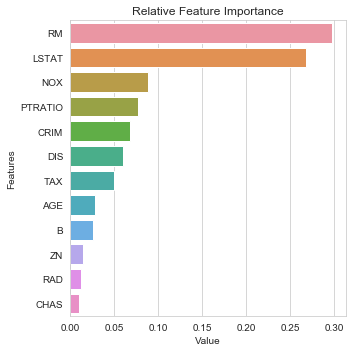

In [44]:
# Visualising feature importance as per the fine tuned RFR fitting result

# Get Feature Importance and sort
col = list(X_test.columns)
sorted(zip(RF_RS_model.feature_importances_,col),reverse=True)

# import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create DataFrame
feature_imp = pd.DataFrame(sorted(zip(RF_RS_model.feature_importances_,col)), columns=['Value','Features'])

# Plot
plt.figure(figsize=(5, 5))
sns.barplot(x="Value", y="Features", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Relative Feature Importance')
plt.tight_layout()
plt.show()

***EXTRA: Partial Dependence Plot***

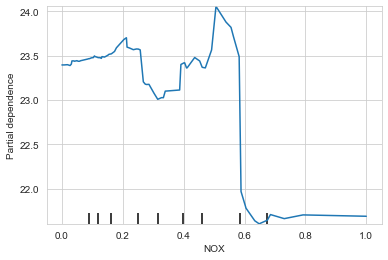

In [46]:
# In addition, we can check the Partial Dependence plot of a chosen variable
# check for NOX (the first feature of X gets index [0], and NOX is the second hence "features = [1]")
plot_partial_dependence(estimator = RF_RS_model, X = X_train, features = [1] ,target='PRICE')